# Credit Risk EDA

This notebook implements a comprehensive credit risk EDA following Basel III/IV
and IFRS 9 frameworks for retail credit portfolio analysis.

Business Objective: Develop PD (Probability of Default) model for retail loans
Regulatory Context: Basel IRB, IFRS 9 ECL, Stress Testing

Import the libraries

In [7]:
import sys
sys.path.append('src')

from feature_engineering import (
    create_fico_score,
    create_fico_band,
    log_transform,
    calculate_credit_history_years,
    create_binary_flags,
    create_vintage_features,
    create_dti_adjusted
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


We first proceed by loading and reading the dataset.

In [8]:
url = "https://www.dropbox.com/scl/fi/gxskg98izg6fmulp22n3r/accepted_2007_to_2018Q4.csv?rlkey=1jl9t026rlg5o009wbf9rbog0&st=eas942l3&dl=1"
df_accepted = pd.read_csv(url, low_memory=False)

Quick data inspection

In [9]:
df_accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_accepted.shape

(2260701, 151)

Our dataset contains more than 2 million observations and 151 variables.

In [11]:
df_accepted.info()

<class 'pandas.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), str(38)
memory usage: 2.5 GB


Remove the duplicates.

In [12]:
df_accepted = df_accepted.drop_duplicates()

Check how many NaN values are present in the dataset.

In [13]:
df_accepted.isnull().sum()

id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64

Some of the variables are (almost) empty, so we remove those whose percentage of NaN values exceed the 1%, i.e., we remove the columns which contain more than 22607 NaN values.

In [14]:
df = df_accepted.loc[:, df_accepted.isnull().sum() / len(df_accepted) < 0.01]

In [15]:
df.shape

(2260701, 56)

We have reduced the number of variables to just 56! However, on those variables left, we have to deal with the missing data. The way of proceeding is to impute the mean to the numerical variables and the mode to the categorical columns.

In [16]:
# Split categorical and numerical columns
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(exclude='number').columns

# Imputers
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

df.loc[:, num_cols] = mean_imputer.fit_transform(df[num_cols])
df.loc[:, cat_cols] = mode_imputer.fit_transform(df[cat_cols])


In [17]:
df.isnull().sum()

id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prnc

No NaN values left!

In [18]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,...,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2260701.0,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06,2.260701e+06
mean,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,...,3.429346e+03,6.876610e+02,6.755397e+02,1.814580e-02,1.0,4.147942e-03,8.464413e-03,1.236983e+01,1.281935e-01,4.677109e-02
std,9.190178e+03,9.188346e+03,9.192265e+03,4.832103e+00,2.671716e+02,1.126953e+05,1.417786e+01,8.672184e-01,3.301014e+01,3.301100e+01,...,6.018204e+03,7.296990e+01,1.110968e+02,1.508072e-01,0.0,6.961561e-02,1.048057e-01,7.264548e+02,3.645002e-01,3.775223e-01
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,6.140000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.190000e+01,0.000000e+00,6.750000e+02,6.790000e+02,...,3.103300e+02,6.540000e+02,6.500000e+02,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.785000e+01,0.000000e+00,6.900000e+02,6.940000e+02,...,6.005900e+02,6.990000e+02,6.950000e+02,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.448000e+01,0.000000e+00,7.150000e+02,7.190000e+02,...,3.743590e+03,7.340000e+02,7.300000e+02,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,8.500000e+02,...,4.219205e+04,8.500000e+02,8.450000e+02,2.000000e+01,1.0,1.400000e+01,1.000000e+01,2.499250e+05,1.200000e+01,8.500000e+01


We now print all the variables and check whether they are categorical or numerical.

In [19]:
df.info(verbose=True)

<class 'pandas.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 56 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          str    
 1   loan_amnt                   float64
 2   funded_amnt                 float64
 3   funded_amnt_inv             float64
 4   term                        str    
 5   int_rate                    float64
 6   installment                 float64
 7   grade                       str    
 8   sub_grade                   str    
 9   home_ownership              str    
 10  annual_inc                  float64
 11  verification_status         str    
 12  issue_d                     str    
 13  loan_status                 str    
 14  pymnt_plan                  str    
 15  url                         str    
 16  purpose                     str    
 17  zip_code                    str    
 18  addr_state                  str    
 19  dti                         floa

Do the same for the categorical variables

In [20]:
df.select_dtypes('object')

C:\Users\jose_\AppData\Local\Temp\ipykernel_23748\2007678513.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  df.select_dtypes('object')


,id,term,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,...,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,...,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,...,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,...,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,66310712,60 months,C,C5,MORTGAGE,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,...,076xx,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,...,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,60 months,B,B3,MORTGAGE,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,...,907xx,CA,Feb-1995,f,Mar-2019,Mar-2019,Individual,N,Cash,N
2260697,88224441,60 months,C,C4,RENT,Not Verified,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,...,334xx,FL,Jul-1999,f,Oct-2017,Mar-2019,Individual,N,Cash,Y
2260698,88215728,60 months,C,C4,MORTGAGE,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,...,770xx,TX,Jun-1996,w,Mar-2019,Mar-2019,Individual,N,Cash,N
2260699,Total amount funded in policy code 1: 1465324575,36 months,B,C1,MORTGAGE,Source Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,...,112xx,CA,Sep-2004,w,Mar-2019,Mar-2019,Individual,N,Cash,N


We continue by inspecting few variables.

In [21]:
df['grade'].unique()

<StringArray>
['C', 'B', 'F', 'A', 'E', 'D', 'G']
Length: 7, dtype: str

And the response variable we seek to predict.

In [22]:
df["loan_status"].unique()

<StringArray>
[                                         'Fully Paid',
                                             'Current',
                                         'Charged Off',
                                     'In Grace Period',
                                  'Late (31-120 days)',
                                   'Late (16-30 days)',
                                             'Default',
  'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off']
Length: 9, dtype: str

## Target variable definition
We now create the (binary) target

In [23]:
default_status = ['Charged Off', 'Default','Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']

# Copy the dataset for good practice
df = df.copy()

# Create binary target
df['default'] = df['loan_status'].isin(default_status).astype(int)

# Performance loans for comparison
performing_status = ['Fully Paid', 'Current']
df['performing'] = df['loan_status'].isin(performing_status).astype(int)

In [24]:
# Portfolio-level statistics
portfolio_default_rate = df['default'].mean()
total_loans = len(df)
defaulted_loans = df['default'].sum()
performing_loans = df['performing'].sum()

In [25]:
print(f"✓ Target variable created (Basel-aligned definition)")
print(f"\nPORTFOLIO STATISTICS:")
print(f"  - Total loans: {total_loans:,}")
print(f"  - Defaulted loans: {defaulted_loans:,}")
print(f"  - Performing loans: {performing_loans:,}")
print(f"  - Portfolio Default Rate: {portfolio_default_rate:.2%}")

# Default rate by loan status
print("\nLoan Status Distribution:")
status_dist = df['loan_status'].value_counts()
print(status_dist)

# Default rate by grade (validation of internal rating system)
print("\nDefault Rate by Internal Grade:")
default_by_grade = df.groupby('grade')['default'].agg(['mean', 'count', 'sum'])
default_by_grade.columns = ['Default_Rate', 'Total_Loans', 'Defaulted_Loans']
default_by_grade['Default_Rate'] = default_by_grade['Default_Rate'] * 100
print(default_by_grade)

print(f" Disbalanced ratio: {performing_loans/defaulted_loans:.2f}:1 (Not Default:Default)")

✓ Target variable created (Basel-aligned definition)

PORTFOLIO STATISTICS:
  - Total loans: 2,260,701
  - Defaulted loans: 290,827
  - Performing loans: 1,955,101
  - Portfolio Default Rate: 12.86%

Loan Status Distribution:
loan_status
Fully Paid                                             1076784
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Default Rate by Internal Grade:
       Default_Rate  Total_Loans  Defaulted_Loans
grade                                            
A          3.587767       433027    

## (Light) Feature engineering

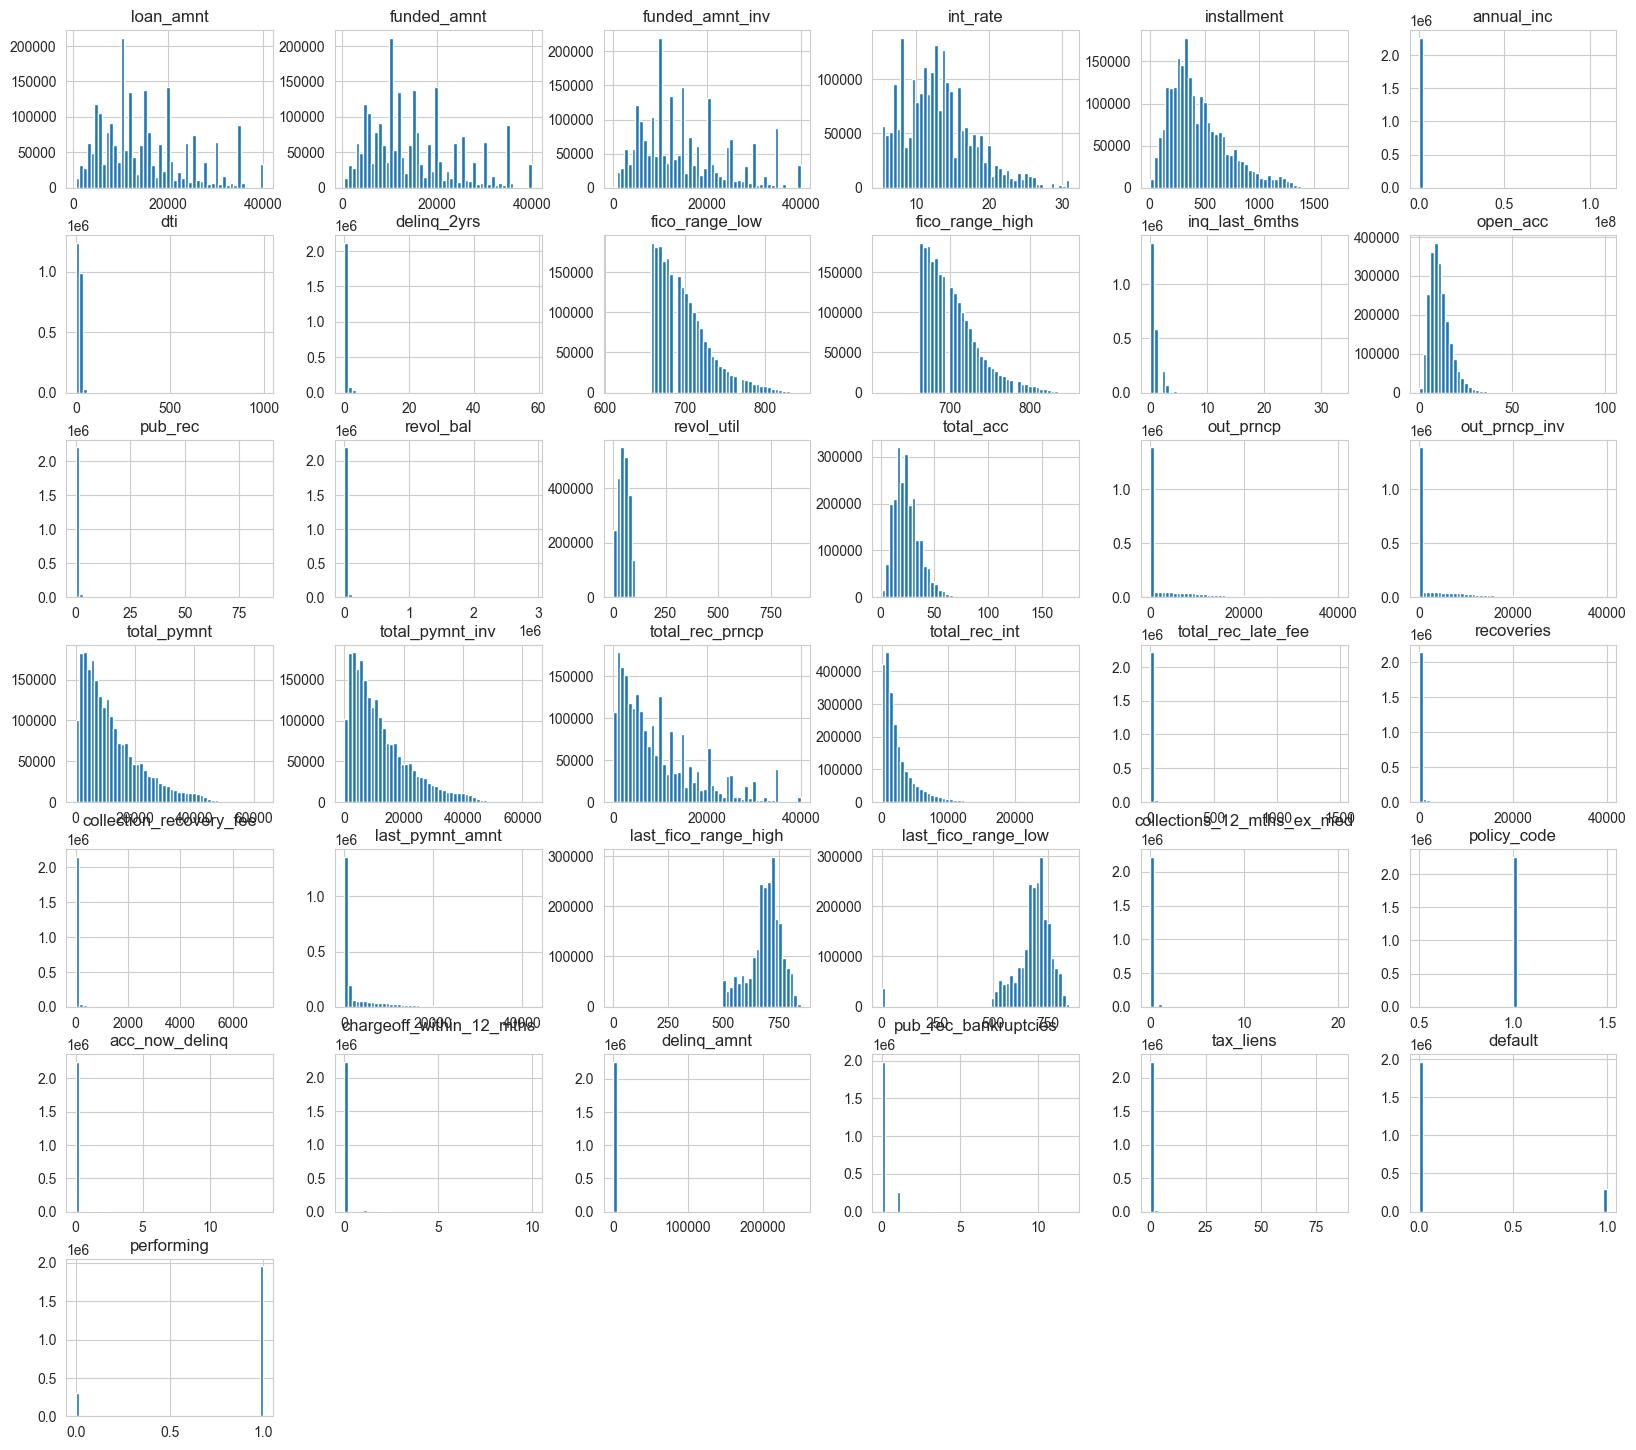

In [26]:
df.hist(bins=50, figsize=(20,18))
plt.show()

We have a problem with the annual income and many other variables like 'last_pymnt_amnt'. It seems that there are larger values which create a heavily right-skewed distribution with extreme outliers that can distort model performance. A logarithmic transformation should be applied to normalize this distribution and reduce the impact of these extreme values.

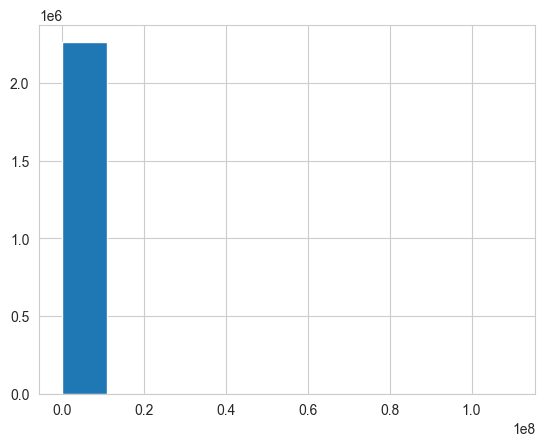

In [27]:
df['annual_inc'].hist(bins=10)
plt.show()

In [28]:
log_num_cols = ["annual_inc", "last_pymnt_amnt"]
for col in log_num_cols:
    df[col+"_log1p"] = np.log1p(df[col])


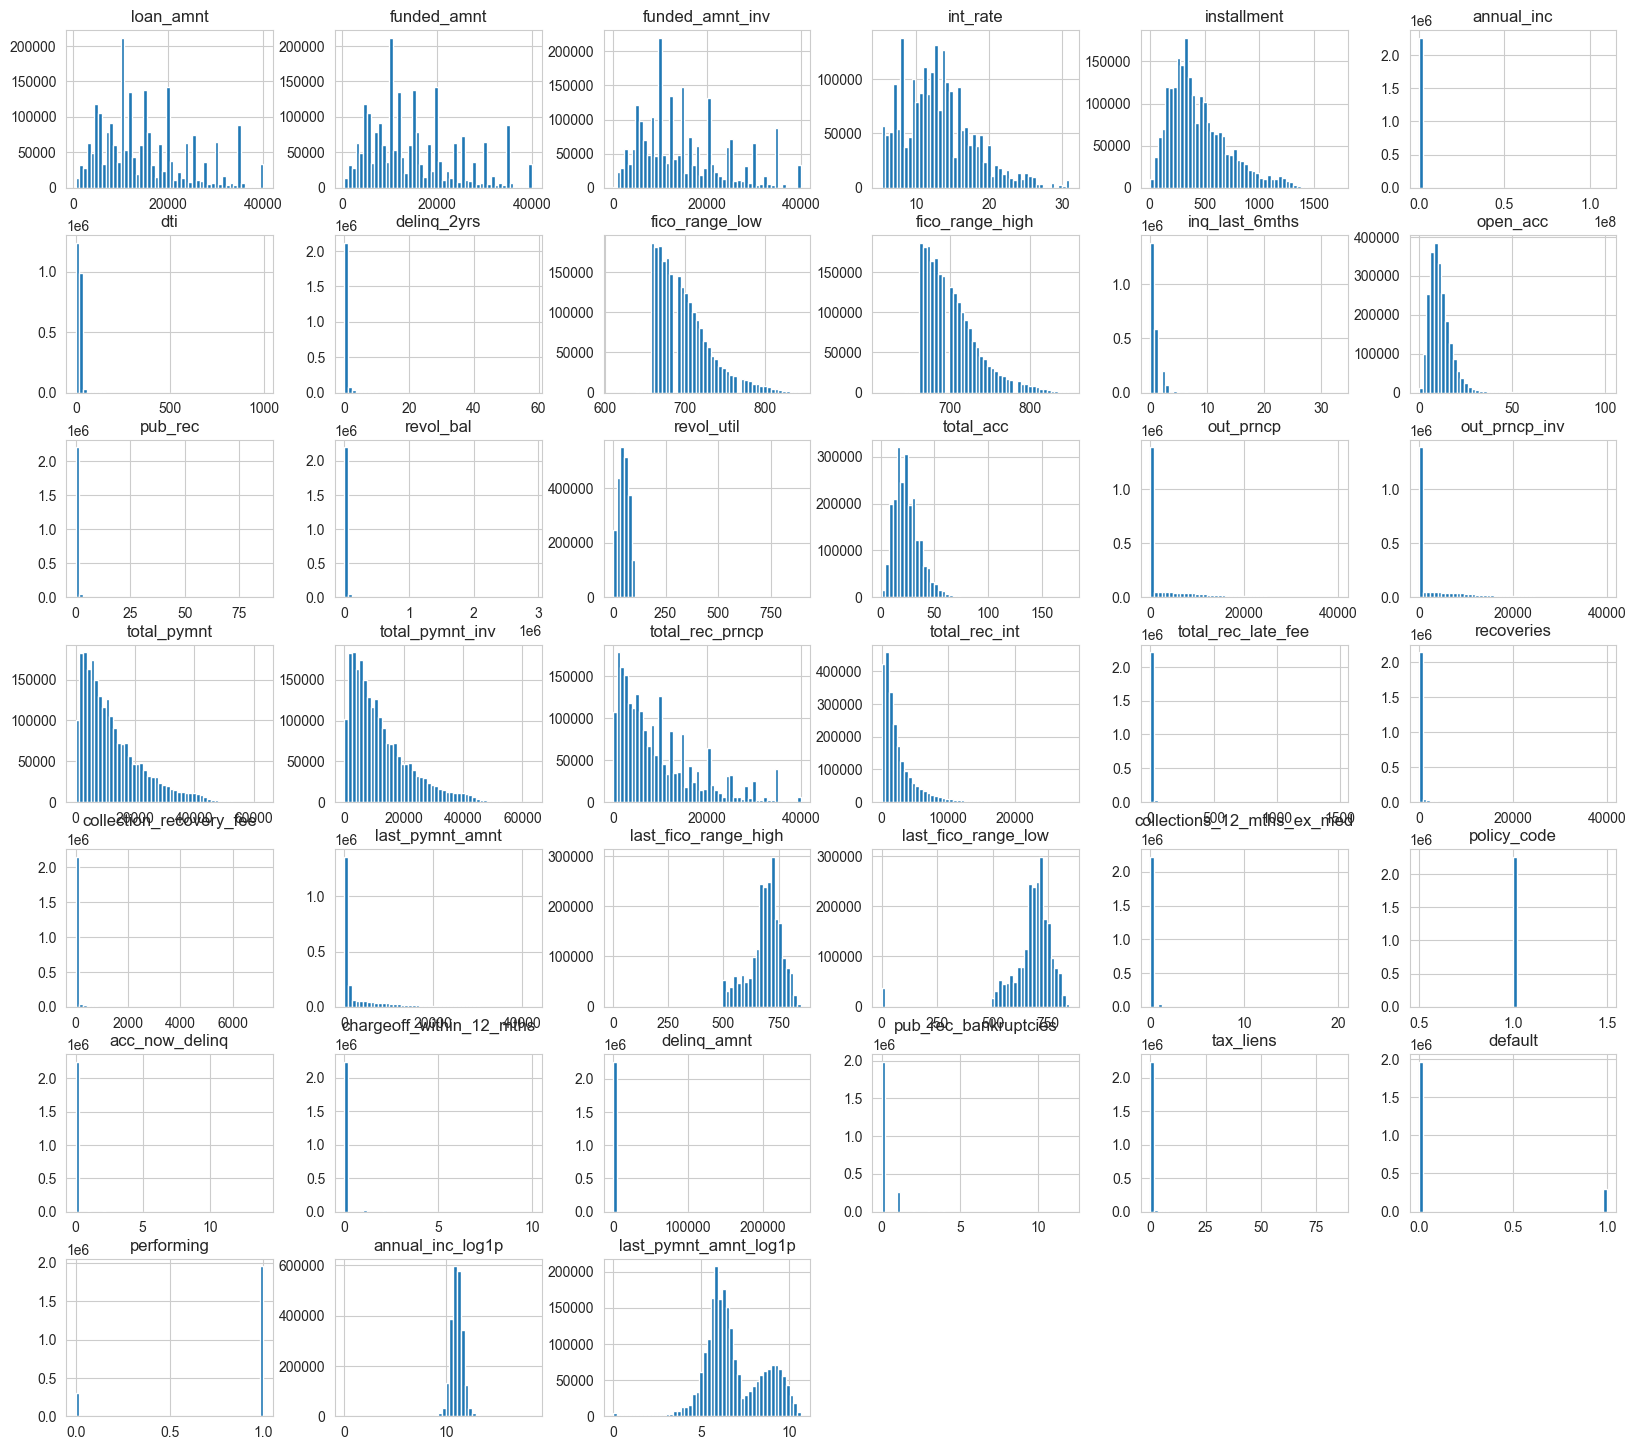

In [29]:
df.hist(bins=50, figsize=(20,18))
plt.show()

In [30]:
# FICO midpoint (industry standard)
df['fico_score'] = create_fico_score(df, 'fico_range_low', 'fico_range_high' )

# FICO bands for scorecard development
df['fico_band'] = create_fico_band(df['fico_score'])

In [31]:
# Credit history length (years)
df['credit_history_years'] = calculate_credit_history_years(df, 'earliest_cr_line', 'issue_d')

# Behavioral flags
create_binary_flags(df)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,...,default,performing,annual_inc_log1p,last_pymnt_amnt_log1p,fico_score,fico_band,credit_history_years,has_delinquency,has_public_records,has_bankruptcy
0,68407277,3600.000000,3600.000000,3600.000000,36 months,13.990000,123.030000,C,C4,MORTGAGE,...,0,1,10.915107,4.817617,677.000000,Good,12.334018,0,0,0
1,68355089,24700.000000,24700.000000,24700.000000,36 months,11.990000,820.280000,C,C1,MORTGAGE,...,0,1,11.082158,6.832331,717.000000,Good,16.000000,1,0,0
2,68341763,20000.000000,20000.000000,20000.000000,60 months,10.780000,432.660000,B,B4,MORTGAGE,...,0,1,11.050906,9.668670,697.000000,Good,15.331964,0,0,0
3,66310712,35000.000000,35000.000000,35000.000000,60 months,14.850000,829.900000,C,C5,MORTGAGE,...,0,1,11.608245,6.722509,787.000000,Very Good,7.247091,0,0,0
4,68476807,10400.000000,10400.000000,10400.000000,60 months,22.450000,289.910000,F,F1,MORTGAGE,...,0,1,11.556311,9.223253,697.000000,Good,17.500342,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,40000.000000,40000.000000,40000.000000,60 months,10.490000,859.560000,B,B3,MORTGAGE,...,0,1,12.332710,6.757583,707.000000,Good,21.664613,1,0,0
2260697,88224441,24000.000000,24000.000000,24000.000000,60 months,14.490000,564.560000,C,C4,RENT,...,1,0,11.608245,6.337816,662.000000,Fair,17.253936,0,1,1
2260698,88215728,14000.000000,14000.000000,14000.000000,60 months,14.490000,329.330000,C,C4,MORTGAGE,...,0,1,11.461643,5.800092,662.000000,Fair,20.334018,0,0,0
2260699,Total amount funded in policy code 1: 1465324575,15046.931228,15041.664057,15023.437745,36 months,13.092829,445.806823,B,C1,MORTGAGE,...,0,1,11.264380,8.140416,700.588302,Good,11.496235,1,1,1


## Univariate Analysis

In [37]:
df['issue_d'] = pd.to_datetime(df['issue_d'],  format='%b-%Y', errors='coerce')

In [38]:
print(f"Date range: {df['issue_d'].min()} to {df['issue_d'].max()}")
print(f"Loans with valid issued date: {df['issue_d'].notna().sum():,}")

# Vintage features
df['vintage_year'] = df['issue_d'].dt.year
df['vintage_quarter'] = df['issue_d'].dt.to_period('Q')

# Loan age/seasoning (months from origination to observation date)
observation_date = pd.to_datetime('2018-12-01')
df['loan_age_months'] = (observation_date - df['issue_d']).dt.days / 30

Date range: 2007-06-01 00:00:00 to 2018-12-01 00:00:00
Loans with valid issued date: 2,260,701


#### Default vs. Features

In [39]:
# Default rate by categorical variables
categorical_vars = ['grade', 'fico_band', 'home_ownership', 'purpose']

for var in categorical_vars:
    if var in df.columns:
        default_rates = df.groupby(var)['default'].agg(['mean', 'count'])
        default_rates.columns = ['Default_Rate', 'Count']
        default_rates['Default_Rate'] = default_rates['Default_Rate'] * 100
        print(f"\nDefault Rate by {var}:")
        print(default_rates.sort_values('Default_Rate', ascending=False).head(10))


Default Rate by grade:
       Default_Rate   Count
grade                      
G         40.006575   12168
F         36.423445   41800
E         28.284638  135639
D         20.351454  324424
C         14.361752  650053
B          8.657303  663590
A          3.587767  433027

Default Rate by fico_band:
             Default_Rate    Count
fico_band                         
Fair            18.250922   367828
Good            12.907926  1610801
Very Good        5.826933   251024
Exceptional      3.694280    31048

Default Rate by home_ownership:
                Default_Rate    Count
home_ownership                       
OTHER              20.879121      182
RENT               14.961634   894929
NONE               14.814815       54
OWN                12.885239   253057
MORTGAGE           11.174620  1111483
ANY                 7.429719      996

Default Rate by purpose:
                    Default_Rate    Count
purpose                                  
educational            20.754717      4

### Vintage curves

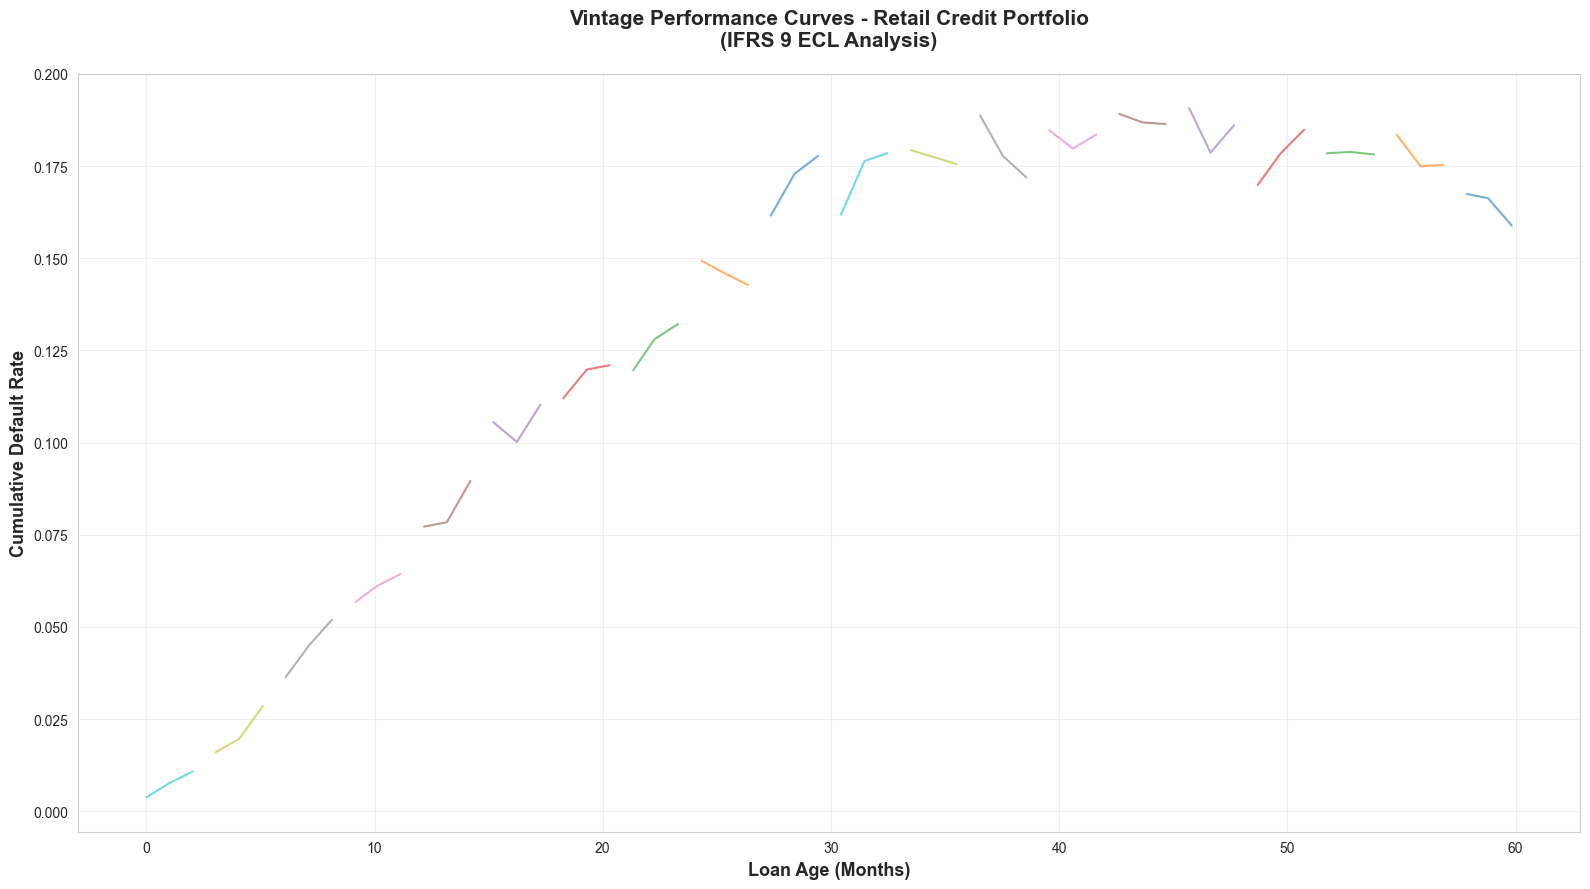

In [40]:
# Filter out loans with missing vintage data
df_vintage = df.dropna(subset=['vintage_quarter', 'loan_age_months'])

# Group by vintage and age
vintage_performance = df_vintage.groupby(['vintage_quarter', 'loan_age_months'])['default'].mean().unstack(level=0)

plt.figure(figsize=(16, 9))

# Plot last 20 vintages
n_vintages = min(20, len(vintage_performance.columns))
for col in vintage_performance.columns[-n_vintages:]:
    plt.plot(vintage_performance.index, vintage_performance[col], alpha=0.6, linewidth=1.5)

plt.xlabel('Loan Age (Months)', fontsize=13, fontweight='bold')
plt.ylabel('Cumulative Default Rate', fontsize=13, fontweight='bold')
plt.title('Vintage Performance Curves - Retail Credit Portfolio\n(IFRS 9 ECL Analysis)',
          fontsize=15, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Default by grade and FICO



 Generating Default by Risk Segments...


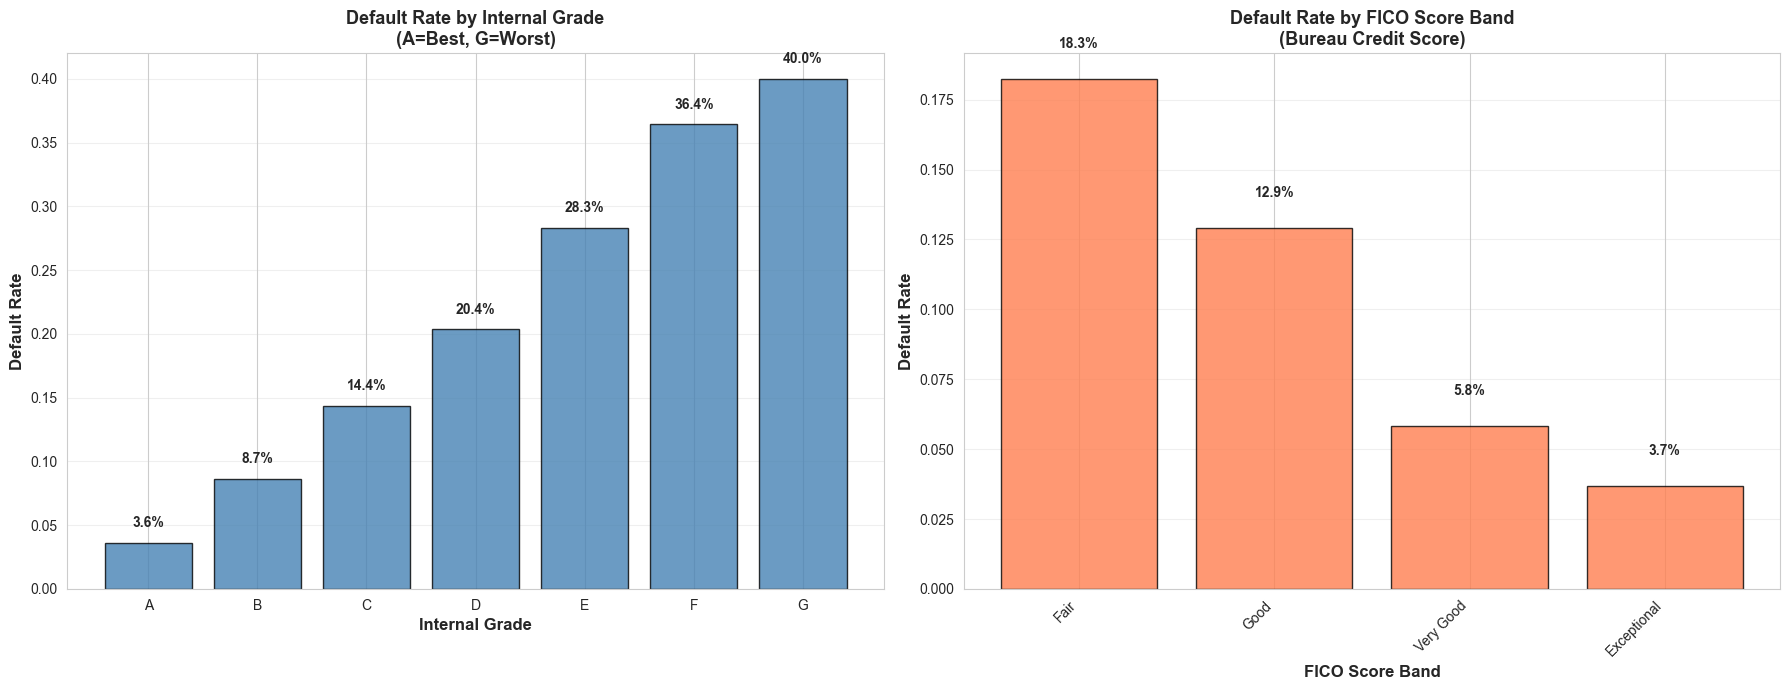

In [41]:
print("\n Generating Default by Risk Segments...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Default rate by grade
grade_default = df.groupby('grade')['default'].mean().sort_index()
axes[0].bar(grade_default.index, grade_default.values, color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Internal Grade', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Default Rate', fontsize=12, fontweight='bold')
axes[0].set_title('Default Rate by Internal Grade\n(A=Best, G=Worst)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(grade_default.values):
    axes[0].text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')

# Default rate by FICO band
fico_default = df.groupby('fico_band', observed=True)['default'].mean()
axes[1].bar(range(len(fico_default)), fico_default.values, color='coral', alpha=0.8, edgecolor='black')
axes[1].set_xticks(range(len(fico_default)))
axes[1].set_xticklabels(fico_default.index, rotation=45, ha='right')
axes[1].set_xlabel('FICO Score Band', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Default Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Default Rate by FICO Score Band\n(Bureau Credit Score)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(fico_default.values):
    axes[1].text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

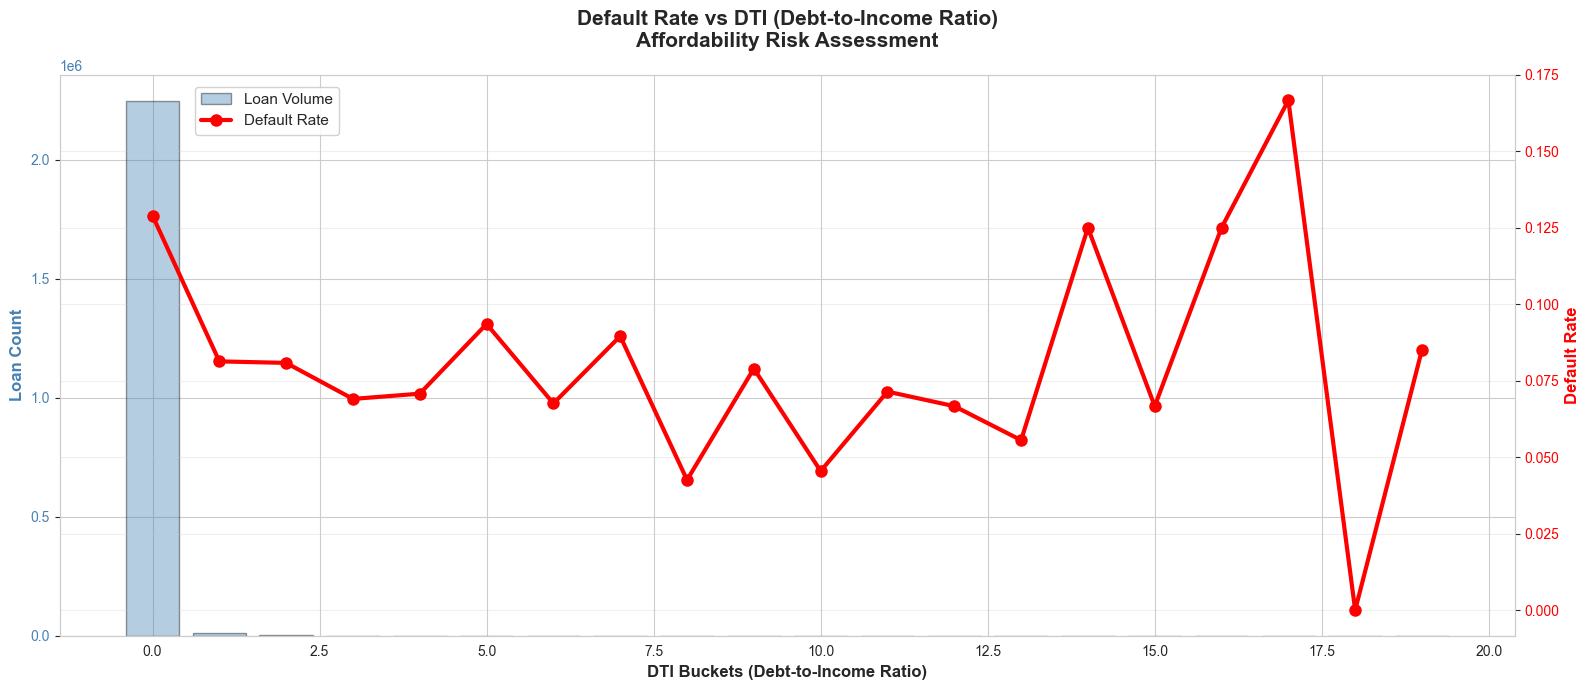

In [42]:
# Bin DTI into 20 buckets for granular analysis
df_dti = df.dropna(subset=['dti', 'default'])
dti_bins = pd.cut(df_dti['dti'], bins=20)
dti_default = df_dti.groupby(dti_bins)['default'].agg(['mean', 'count'])

fig, ax1 = plt.subplots(figsize=(16, 7))

# Volume bars
ax1.bar(range(len(dti_default)), dti_default['count'], alpha=0.4,
        label='Loan Volume', color='steelblue', edgecolor='black')
ax1.set_xlabel('DTI Buckets (Debt-to-Income Ratio)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loan Count', fontsize=12, fontweight='bold', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Default rate line
ax2 = ax1.twinx()
ax2.plot(range(len(dti_default)), dti_default['mean'], color='red',
         marker='o', label='Default Rate', linewidth=3, markersize=8)
ax2.set_ylabel('Default Rate', fontsize=12, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Default Rate vs DTI (Debt-to-Income Ratio)\nAffordability Risk Assessment',
          fontsize=15, fontweight='bold', pad=20)
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Correlation matrix

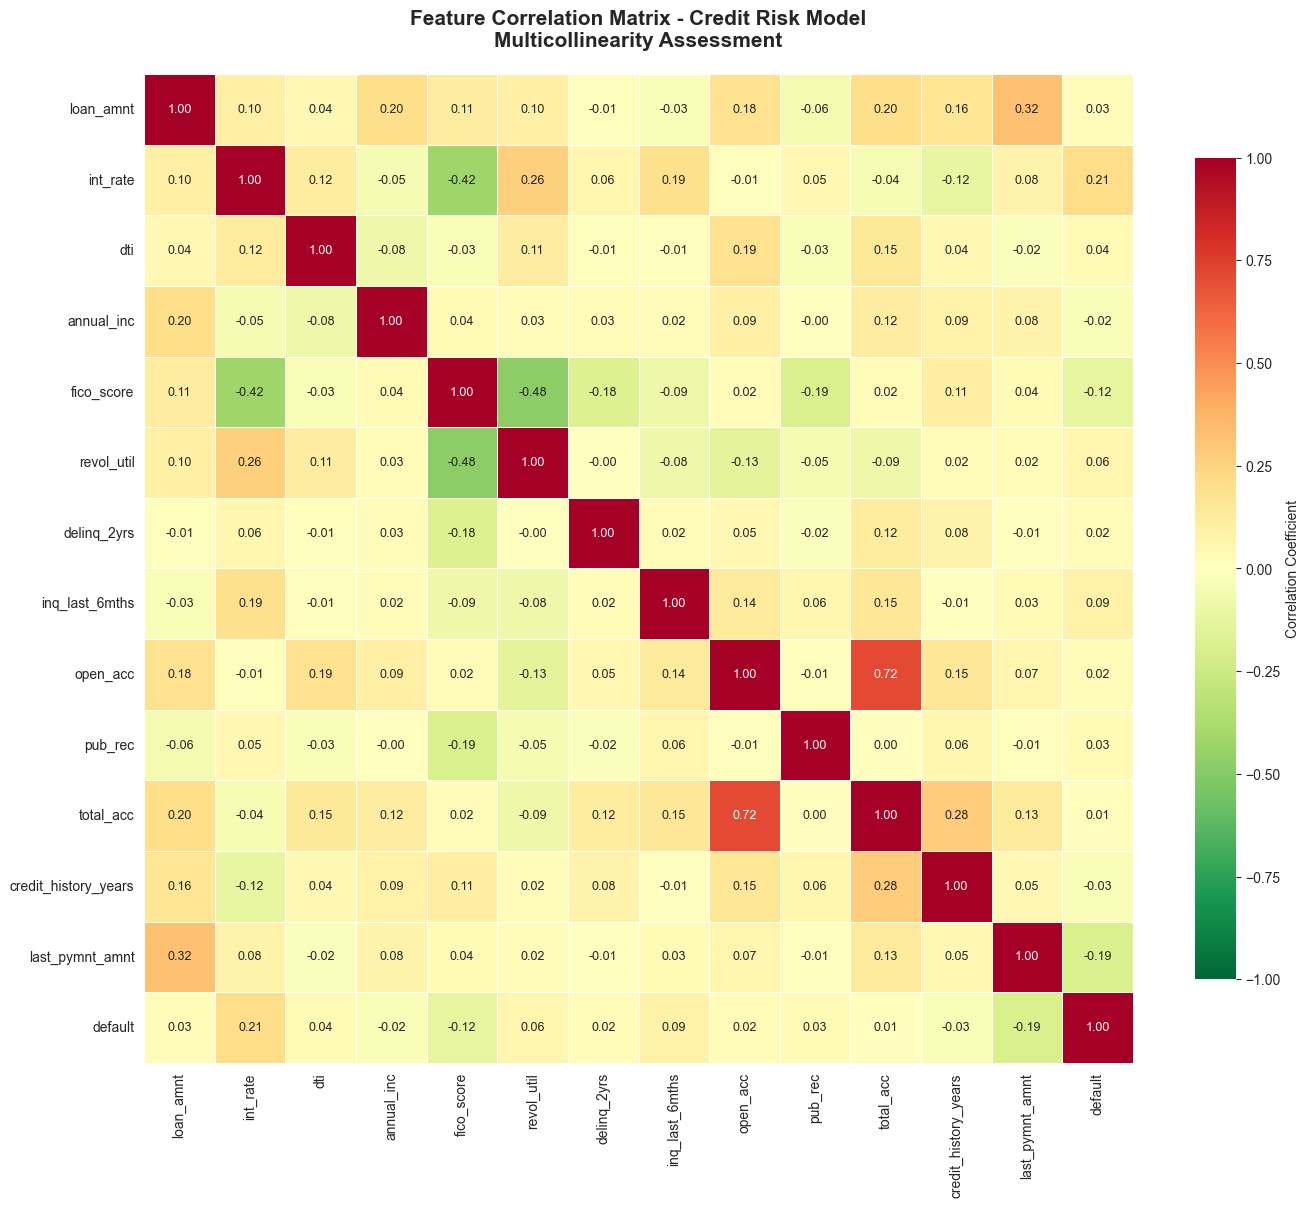

In [43]:
# Select key features for correlation analysis
key_features = [
    'loan_amnt', 'int_rate', 'dti', 'annual_inc',
    'fico_score', 'revol_util', 'delinq_2yrs',
    'inq_last_6mths', 'open_acc', 'pub_rec',
    'total_acc', 'credit_history_years', 'last_pymnt_amnt', 'default'
]

# Compute correlation matrix
correlation_matrix = df[key_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
            annot_kws={'fontsize': 9})
plt.title('Feature Correlation Matrix - Credit Risk Model\nMulticollinearity Assessment',
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Regulatory Analysis

#### LOW DEFAULT PORTFOLIO (LDP) IDENTIFICATION

In [45]:
# Identify segments with default rate < 0.5% (regulatory LDP threshold)
ldp_segments = df.groupby(['grade', 'fico_band'], observed=True)['default'].agg(['mean', 'count'])
ldp_segments = ldp_segments[ldp_segments['mean'] < 0.005]

ldp_segments.columns = ['Default_Rate', 'Loan_Count']
ldp_segments['Default_Rate'] = ldp_segments['Default_Rate'] * 100

print(f"Found {len(ldp_segments)} LDP segments (default rate < 0.5%):")
print(ldp_segments.sort_values('Loan_Count', ascending=False).head(15))

Found 0 LDP segments (default rate < 0.5%):
Empty DataFrame
Columns: [Default_Rate, Loan_Count]
Index: []


#### Concentration risk analysis

In [46]:
purpose_concentration = df.groupby('purpose').agg({
    'loan_amnt': 'sum',
    'default': 'mean',
    'id': 'count'
}).sort_values('loan_amnt', ascending=False)

purpose_concentration['exposure_pct'] = (
    purpose_concentration['loan_amnt'] / purpose_concentration['loan_amnt'].sum() * 100
)

purpose_concentration.columns = ['Total_Exposure_$', 'Default_Rate', 'Loan_Count', 'Exposure_%']
purpose_concentration['Default_Rate'] = purpose_concentration['Default_Rate'] * 100

print("\nTop Purpose Concentrations:")
print(purpose_concentration.head(10))


Top Purpose Concentrations:
                    Total_Exposure_$  Default_Rate  Loan_Count  Exposure_%
purpose                                                                   
debt_consolidation      2.040397e+10     13.913499     1277910   59.982369
credit_card             7.919856e+09     10.459194      516971   23.282319
home_improvement        2.206625e+09     11.310208      150457    6.486903
other                   1.461483e+09     12.989099      139440    4.296381
major_purchase          6.397652e+08     12.024978       50445    1.880743
small_business          4.059537e+08     20.215481       24689    1.193398
medical                 2.604266e+08     13.478609       27488    0.765586
car                     2.255714e+08      9.782201       24013    0.663121
house                   2.219906e+08     12.634409       14136    0.652595
moving                  1.292437e+08     15.626826       15403    0.379943



#### STRESS TESTING - 2007-2008 FINANCIAL CRISIS


In [47]:
# Crisis period analysis
crisis_years = [2007, 2008]
df_crisis = df[df['vintage_year'].isin(crisis_years)]
df_normal = df[~df['vintage_year'].isin(crisis_years)]

crisis_performance = df_crisis.groupby('vintage_year')['default'].agg(['mean', 'count'])
normal_performance = df_normal.groupby('vintage_year')['default'].mean().mean()

crisis_performance.columns = ['Default_Rate', 'Loan_Count']
crisis_performance['Default_Rate'] = crisis_performance['Default_Rate'] * 100

print("\nCrisis Period Performance (2007-2009):")
print(crisis_performance)

crisis_avg = df_crisis['default'].mean()
print(f"\nNormal Period Average Default Rate: {normal_performance:.2%}")
print(f"Crisis Period Average Default Rate: {crisis_avg:.2%}")
print(f"Stress Multiplier: {crisis_avg / normal_performance:.2f}x")



Crisis Period Performance (2007-2009):
              Default_Rate  Loan_Count
vintage_year                          
2007             26.202322         603
2008             20.727121        2393

Normal Period Average Default Rate: 14.13%
Crisis Period Average Default Rate: 21.83%
Stress Multiplier: 1.55x


#### BASEL IRB SEGMENTATION

In [48]:
irb_segments = df.groupby('grade').agg({
    'default': 'mean',
    'loan_amnt': 'sum',
    'id': 'count'
})

irb_segments.columns = ['PD_Estimate', 'Total_EAD_$', 'Obligor_Count']
irb_segments['PD_Estimate'] = irb_segments['PD_Estimate'] * 100
irb_segments['EAD_%'] = irb_segments['Total_EAD_$'] / irb_segments['Total_EAD_$'].sum() * 100

print("\nIRB Risk Segments (by Internal Grade):")
print(irb_segments)


IRB Risk Segments (by Internal Grade):
       PD_Estimate   Total_EAD_$  Obligor_Count      EAD_%
grade                                                     
A         3.587767  6.323642e+09         433027  18.589864
B         8.657303  9.405314e+09         663590  27.649180
C        14.361752  9.775551e+09         650053  28.737580
D        20.351454  5.097344e+09         324424  14.984868
E        28.284638  2.367318e+09         135639   6.959300
F        36.423445  7.994102e+08          41800   2.350058
G        40.006575  2.480324e+08          12168   0.729151


### Data Quality Evaluation

In [49]:
# Outlier detection for key variables
numerical_vars = ['loan_amnt', 'annual_inc', 'dti', 'revol_util', 'int_rate']

for var in numerical_vars:
    if var in df.columns:
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)][var]
        outlier_pct = len(outliers) / len(df) * 100

        print(f"\n  {var}:")
        print(f"    - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
        print(f"    - Outliers: {len(outliers):,} ({outlier_pct:.2%})")

# Data consistency checks
# Check for logical inconsistencies
print(f"\n  - Loans with DTI > 100%: {(df['dti'] > 100).sum():,}")
print(f"  - Loans with negative amounts: {(df['loan_amnt'] < 0).sum():,}")
print(f"  - Loans with FICO < 300: {(df['fico_score'] < 300).sum():,}")


  loan_amnt:
    - Q1: 8000.00, Q3: 20000.00, IQR: 12000.00
    - Outliers: 35,215 (155.77%)

  annual_inc:
    - Q1: 46000.00, Q3: 93000.00, IQR: 47000.00
    - Outliers: 110,041 (486.76%)

  dti:
    - Q1: 11.90, Q3: 24.48, IQR: 12.58
    - Outliers: 21,633 (95.69%)

  revol_util:
    - Q1: 31.50, Q3: 69.30, IQR: 37.80
    - Outliers: 119 (0.53%)

  int_rate:
    - Q1: 9.49, Q3: 15.99, IQR: 6.50
    - Outliers: 41,099 (181.80%)

  - Loans with DTI > 100%: 2,561
  - Loans with negative amounts: 0
  - Loans with FICO < 300: 0


### KEY FINDINGS

In [50]:
print("\n1. PORTFOLIO CHARACTERISTICS:")
print(f"   - Total portfolio: {len(df):,} loans, ${df['loan_amnt'].sum()/1e9:.2f}B exposure")
print(f"   - Overall default rate: {portfolio_default_rate:.2%}")
print(f"   - Grade A default rate: {default_by_grade.loc['A', 'Default_Rate']/100:.2%}")
print(f"   - Grade G default rate: {default_by_grade.loc['G', 'Default_Rate']/100:.2%}")

print("\n2. RISK DRIVERS IDENTIFIED:")
print("   ✓ Grade (A→G) shows clear default progression")
print("   ✓ FICO score inversely related to default")
print("   ✓ DTI >40% shows elevated default risk")
print("   ✓ Prior delinquency strong predictor")

print("\n3. REGULATORY INSIGHTS:")
print(f"   - 2007-2008 crisis showed {crisis_avg / normal_performance:.1f}x stress multiplier")
print(f"   - {len(ldp_segments)} LDP segments identified (<0.5% default rate)")
print(f"   - Top 3 purposes account for {purpose_concentration.head(3)['Exposure_%'].sum():.1f}% exposure")


1. PORTFOLIO CHARACTERISTICS:
   - Total portfolio: 2,260,701 loans, $34.02B exposure
   - Overall default rate: 12.86%
   - Grade A default rate: 3.59%
   - Grade G default rate: 40.01%

2. RISK DRIVERS IDENTIFIED:
   ✓ Grade (A→G) shows clear default progression
   ✓ FICO score inversely related to default
   ✓ DTI >40% shows elevated default risk
   ✓ Prior delinquency strong predictor

3. REGULATORY INSIGHTS:
   - 2007-2008 crisis showed 1.5x stress multiplier
   - 0 LDP segments identified (<0.5% default rate)
   - Top 3 purposes account for 89.8% exposure
